# Trevor Dorn-Wallenstein
# 1/22/18
# Looking for outliers in color/magnitude space?

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits, ascii
from glob import glob
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord
import astropy.units as u

%matplotlib inline

In [2]:
phot_table = Table(ascii.read('../data/1_17_18/photometry/all_photometry.dat'))

member_hdu = fits.open('../info/cluster_members.fits')
spectr_hdu = fits.open('../info/spectro_targets.fits')

member_table = Table(member_hdu[1].data)
spectr_table = Table(spectr_hdu[1].data)

phot_coords = SkyCoord(phot_table['RA'],phot_table['Dec'],unit=(u.hourangle, u.deg))
member_coords = SkyCoord(member_table['RAJ2000']*u.deg,member_table['DEJ2000']*u.deg)
spec_coords = SkyCoord(spectr_table['RAJ2000']*u.deg,spectr_table['DEJ2000']*u.deg)

idx_red, d2d_red, d3d_red = member_coords[(member_table['SpT']<75)&(member_table['SpT']>=50)].match_to_catalog_sky(phot_coords)
idx_blue, d2d_blue, d3d_blue = member_coords[member_table['SpT'] <= 20].match_to_catalog_sky(phot_coords)
idx_spec, d2d_spec, d3d_spec = spec_coords.match_to_catalog_sky(phot_coords)

/Users/carina/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)
/Users/carina/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, oper)(other)
/Users/carina/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, oper)(other)


In [3]:
#Filter to just stars with match closer than 1"
red_idx = idx_red[d2d_red.arcsec <= 1.0]
blue_idx = idx_blue[d2d_blue.arcsec <= 1.0]
spec_idx = idx_spec[d2d_spec.arcsec <= 1.0]

mask = np.ones(len(phot_table),dtype=bool)
spec_mask = np.ones(len(phot_table),dtype=bool)
blue_mask = np.ones(len(phot_table),dtype=bool)
mask[spec_idx] = False
spec_mask[spec_idx] = False
mask[red_idx] = False
blue_mask[blue_idx] = False

candidates = phot_table[mask]
blue_candidates = phot_table[mask&~blue_mask]

spec_cands = phot_table[~spec_mask]

cand_coords = SkyCoord(candidates['RA'],candidates['Dec'],unit=(u.hourangle, u.deg))
blue_coords = SkyCoord(blue_candidates['RA'],blue_candidates['Dec'],unit=(u.hourangle, u.deg))
spec_cand_coords = SkyCoord(spec_cands['RA'],spec_cands['Dec'],unit=(u.hourangle, u.deg))

target_tables = []

In [4]:
idx_mem, d2d_mem, d3d_mem = cand_coords.match_to_catalog_sky(member_coords)
idx_mem_blue, d2d_mem_blue, d3d_mem_blue = blue_coords.match_to_catalog_sky(member_coords)
idx_spectab, d2d_spectab, d3d_spectab = spec_cand_coords.match_to_catalog_sky(spec_coords)

In [5]:
#Look up the V, Ic and SpT of spectroscopic targets that correspond to our targets
spec_V = spectr_table['Vmag'][idx_spectab]
spec_Ic = spectr_table['Icmag'][idx_spectab]
spec_SpT = spectr_table['SpT'][idx_spectab]

V_OB = spec_V[spec_SpT <= 20]
Ic_OB = spec_Ic[spec_SpT <= 20]
HeII4750_OB = spec_cands['WN-CT'][spec_SpT <= 20]

In [6]:
cand_V = member_table['Vmag'][idx_mem]
cand_Ic = member_table['Icmag'][idx_mem]
cand_SpT = member_table['SpT'][idx_mem]

blue_V = member_table['Vmag'][idx_mem_blue]
blue_Ic = member_table['Icmag'][idx_mem_blue]
blue_SpT = member_table['SpT'][idx_mem_blue]
blue_candidates.add_column(Column(blue_V),name='Vmag')
blue_candidates.add_column(Column(blue_Ic),name='Icmag')
blue_candidates.add_column(Column(blue_SpT),name='SpT')

cand_where_phot = candidates[d2d_mem.arcsec <= 1.0]
V_where_phot = cand_V[d2d_mem.arcsec <= 1.0]
Ic_where_phot = cand_Ic[d2d_mem.arcsec <= 1.0]
SpT_where_phot = cand_SpT[d2d_mem.arcsec <= 1.0]


cand_where_phot.add_column(Column(V_where_phot),name='Vmag')
cand_where_phot.add_column(Column(Ic_where_phot),name='Icmag')
cand_where_phot.add_column(Column(SpT_where_phot),name='SpT')

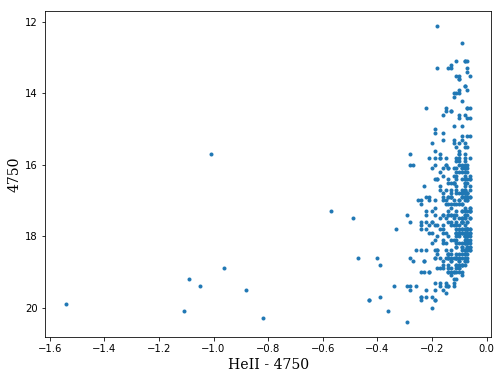

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(phot_table['WN-CT'],phot_table['CT'],marker='.')
plt.gca().invert_yaxis()
plt.xlabel('HeII - 4750',family='serif',fontsize=14)
plt.ylabel('4750',family='serif',fontsize=14)
plt.savefig('../plots/all_APO_photometry.eps')

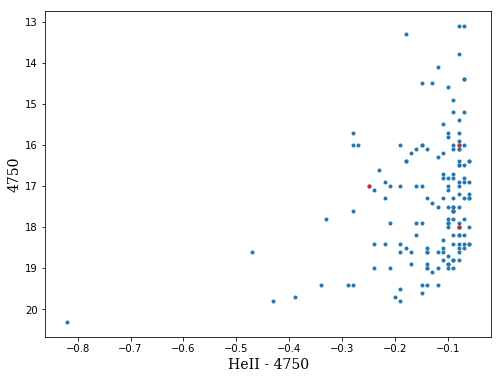

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(candidates['WN-CT'],candidates['CT'],marker='.')
plt.scatter(blue_candidates['WN-CT'],blue_candidates['CT'],marker='.',c='C3')
plt.gca().invert_yaxis()
plt.xlabel('HeII - 4750',family='serif',fontsize=14)
plt.ylabel('4750',family='serif',fontsize=14)
plt.savefig('../plots/apo_photometry_no_spectra.eps')

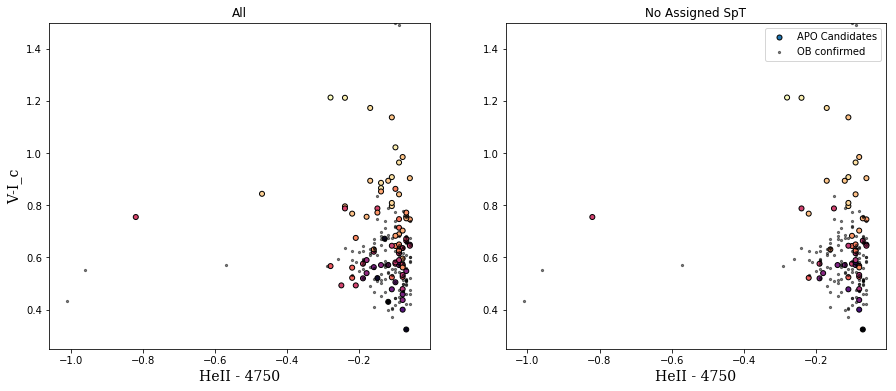

In [9]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
ax0 = ax[0].scatter(cand_where_phot['WN-CT'],V_where_phot-Ic_where_phot,c=V_where_phot,edgecolor='k',s=100,lw=1,cmap='magma',marker='.')
ax[0].scatter(HeII4750_OB,V_OB-Ic_OB,c='k',s=5,alpha=0.5)
ax[0].set_xlabel('HeII - 4750',family='serif',fontsize=14)
ax[0].set_ylabel('V-I_c',family='serif',fontsize=14)
ax[0].set_ylim(0.25,1.5)
ax[0].set_title('All')

nan_idx = np.isnan(SpT_where_phot)
ax1 = ax[1].scatter(cand_where_phot['WN-CT'][nan_idx],V_where_phot[nan_idx]-Ic_where_phot[nan_idx],c=V_where_phot[nan_idx],edgecolor='k',s=100,lw=1,cmap='magma',marker='.',label='APO Candidates')
ax[1].scatter(HeII4750_OB,V_OB-Ic_OB,c='k',s=5,alpha=0.5,label='OB confirmed')
ax[1].set_xlabel('HeII - 4750',family='serif',fontsize=14)
ax[1].set_ylim(0.25,1.5)
ax[1].legend()
ax[1].set_title('No Assigned SpT')
plt.savefig('../plots/no_spectra_two_color.eps')

In [10]:
SpT_where_phot[cand_where_phot['WN-CT'] < -0.4]
#That one in the middle is ~A9-ish?

nan
29.2


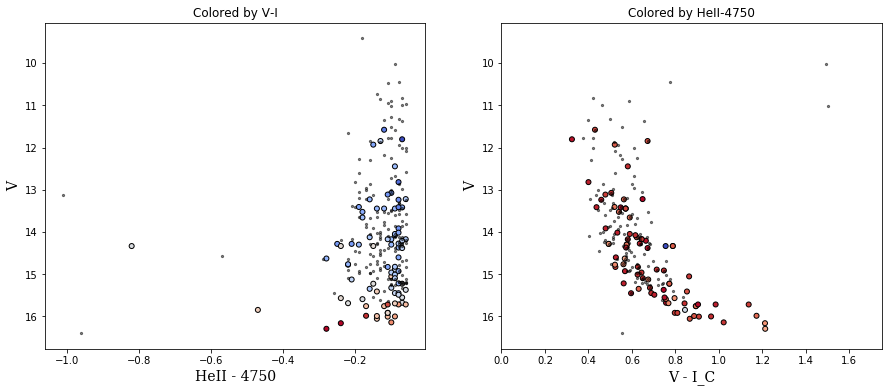

In [11]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
ax0 = ax[0].scatter(cand_where_phot['WN-CT'],V_where_phot,c=V_where_phot-Ic_where_phot,edgecolor='k',s=100,lw=1,cmap='coolwarm',marker='.')
ax[0].scatter(HeII4750_OB,V_OB,c='k',s=5,alpha=0.5)
ax[0].set_xlabel('HeII - 4750',family='serif',fontsize=14)
ax[0].set_ylabel('V',family='serif',fontsize=14)
ax[0].set_title('Colored by V-I')

ax1 = ax[1].scatter(V_where_phot-Ic_where_phot,V_where_phot,c=cand_where_phot['WN-CT'],edgecolor='k',s=100,lw=1,cmap='coolwarm',marker='.')
ax[1].scatter(V_OB-Ic_OB,V_OB,c='k',s=5,alpha=0.5)
ax[1].set_xlabel('V - I_C',family='serif',fontsize=14)
ax[1].set_ylabel('V',family='serif',fontsize=14)
ax[1].set_xlim(0,1.75)
ax[1].set_title('Colored by HeII-4750')

ax[0].invert_yaxis()
ax[1].invert_yaxis()

plt.savefig('../plots/no_spectra_CMD.eps')

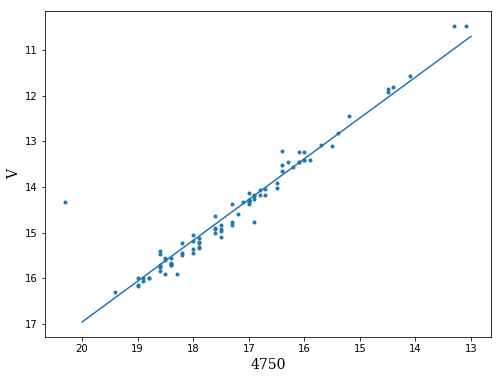

In [12]:
p = np.polyfit(cand_where_phot['CT'],V_where_phot,1)

plt.figure(figsize=(8,6))
plt.scatter(cand_where_phot['CT'],V_where_phot,marker='.')
x = np.linspace(13,20,100)
plt.plot(x,np.poly1d(p)(x))
plt.xlabel('4750',family='serif',fontsize=14)
plt.ylabel('V',family='serif',fontsize=14)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [13]:
np.poly1d(p)(0)
#zeropoint is ~-1

-0.9130305963273733

In [14]:
def calc_exp_time(mag,target_SN_per_ang_in_blue = 20.0):
    return (target_SN_per_ang_in_blue/(3700.0*np.power(10.0,-0.2*mag)))**2.0

In [28]:
#Now let's assemble the targets! First:
target_tables = []

first_list = cand_where_phot[(cand_where_phot['WN-CT'] < -0.4)]
first_list.sort('Vmag')
first_list.add_column(Column(['heii_{}'.format(i+1) for i in range(len(first_list))]),name='TargName')
target_tables.append(first_list)

second_list = cand_where_phot[((cand_where_phot['Vmag']-cand_where_phot['Icmag'])>0.85)]
second_list.sort('Vmag')
second_list.add_column(Column(['red_{}'.format(i+1) for i in range(len(second_list))]),name='TargName')
target_tables.append(second_list)

third_list = blue_candidates.copy()
third_list.sort('Vmag')
third_list.add_column(Column(['blue_{}'.format(i+1) for i in range(len(third_list))]),name='TargName')
target_tables.append(third_list)

targets = vstack(target_tables)
targets.remove_row(7)

exp_times_50 = calc_exp_time(targets['Vmag'],50.0)
exp_times_50.name = 'ExpTime50'
exp_times_20 = calc_exp_time(targets['Vmag'],20.0)
exp_times_20.name = 'ExpTime20'
targets.add_columns([exp_times_50,exp_times_20])
targets.remove_columns(['WN-CT','SigWN-CT','WC-WN','SigWC-WN'])
targets.write('targets.fits',overwrite=True)
print(sum(targets['ExpTime50'])/3600)
targets

/Users/carina/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


1.874657431708442


RA,Dec,CT,He-CT,SigHe-CT,Field,Vmag,Icmag,SpT,TargName,ExpTime50,ExpTime20
str40,str40,float64,float64,float64,str12,float32,float32,float32,str24,float32,float32
2:17:28.65,57:05:27.6,20.3,-0.82,12.9,L20,14.333,13.578,nan,heii_1,98.79538,15.8072605
2:18:22.73,57:03:26.1,18.6,-0.47,23.5,M09,15.845,15.001,29.2,heii_2,397.6828,63.629253
2:18:03.71,57:06:29.3,18.0,-0.1,5.0,H10,15.052,14.189,31.2,red_1,191.57407,30.65185
2:23:03.62,57:14:55.2,18.6,-0.14,5.9,M26,15.409,14.556,25.0,red_2,266.15646,42.585037
2:21:29.88,57:06:22.6,18.4,-0.08,4.1,H32,15.716,14.731,nan,red_3,353.13144,56.501034
2:23:36.21,57:07:04.9,18.4,-0.06,3.0,L07,15.716,14.812,nan,red_4,353.13144,56.501034
2:23:22.64,57:06:30.3,18.6,-0.11,5.1,M23,15.717,14.58,nan,red_5,353.4569,56.553104
2:19:09.41,57:09:17.4,18.6,-0.17,5.6,H03,15.756,14.862,nan,red_7,366.38412,58.621464
2:22:12.87,57:01:27.2,18.9,-0.17,5.7,M29,15.984,14.811,nan,red_8,451.998,72.31968


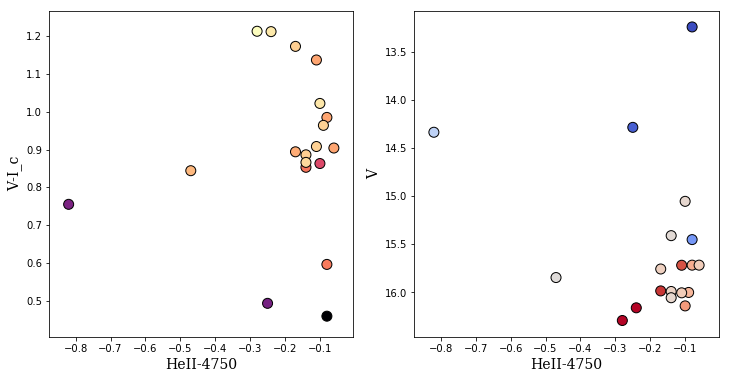

In [16]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(targets['He-CT'],targets['Vmag']-targets['Icmag'],c=targets['Vmag'],cmap='magma',edgecolor='k',s=100,lw=1,)
ax[0].set_xlabel('HeII-4750',family='serif',fontsize=14)
ax[0].set_ylabel('V-I_c',family='serif',fontsize=14)
ax[1].scatter(targets['He-CT'],targets['Vmag'],c=targets['Vmag']-targets['Icmag'],cmap='coolwarm',edgecolor='k',s=100,lw=1,)
ax[1].set_xlabel('HeII-4750',family='serif',fontsize=14)
ax[1].set_ylabel('V',family='serif',fontsize=14)
ax[1].invert_yaxis()

plt.savefig('../plots/target_plots.eps')

In [36]:
finding_table = targets[['TargName','RA','Dec']]
finding_table.rename_column('TargName','objname')
finding_table.rename_column('RA','ra')
finding_table.rename_column('Dec','dec')
finding_table.write('../data/1_25_18/finders/coords.txt',format='ascii',overwrite=True)
finding_table

objname,ra,dec
str24,str40,str40
heii_1,2:17:28.65,57:05:27.6
heii_2,2:18:22.73,57:03:26.1
red_1,2:18:03.71,57:06:29.3
red_2,2:23:03.62,57:14:55.2
red_3,2:21:29.88,57:06:22.6
red_4,2:23:36.21,57:07:04.9
red_5,2:23:22.64,57:06:30.3
red_7,2:19:09.41,57:09:17.4
red_8,2:22:12.87,57:01:27.2
